Project root: C:\Users\yasmi\OneDrive\Desktop\Mini-Projets\GSE147058_DNA_Methylation_Analysis
Processed data folder: C:\Users\yasmi\OneDrive\Desktop\Mini-Projets\GSE147058_DNA_Methylation_Analysis\data\processed
Metadata shape: (96, 17)
Beta matrix shape: (500, 97)
Basic columns found: ['sex']
sex
Male      48
Female    48
Name: count, dtype: int64


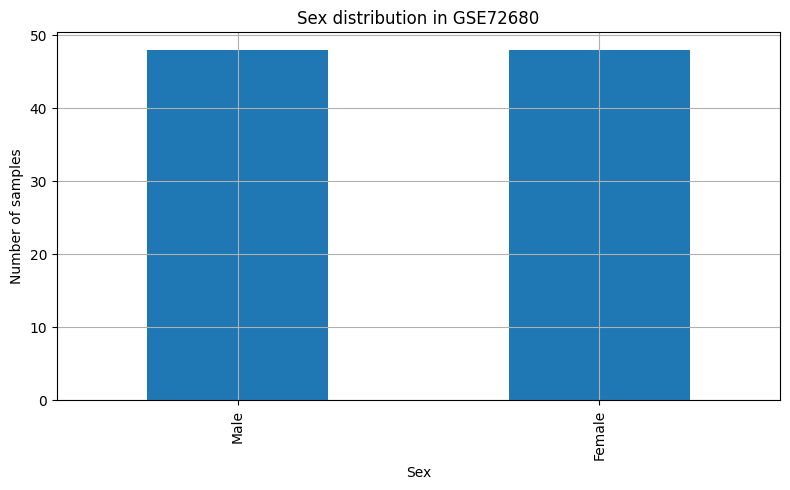

No 'age' column found in metadata.
Potential trauma / abuse / stress columns:
Column 'childhood_sexual/physical_abuse_moderate_to_extreme' not found in metadata. Please adjust the name.
Cannot plot age vs trauma: required columns are missing.
Potential trauma / abuse / stress columns:
Beta matrix shape: (500, 97)
Number of CpG sites: 500
Number of samples: 96


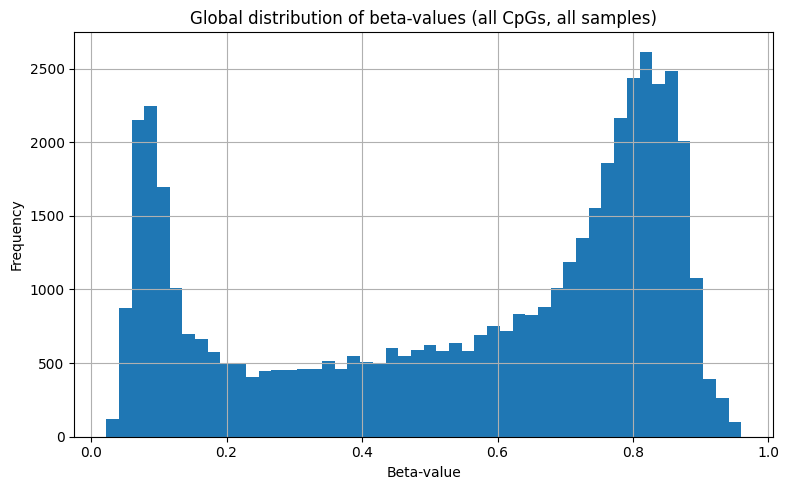

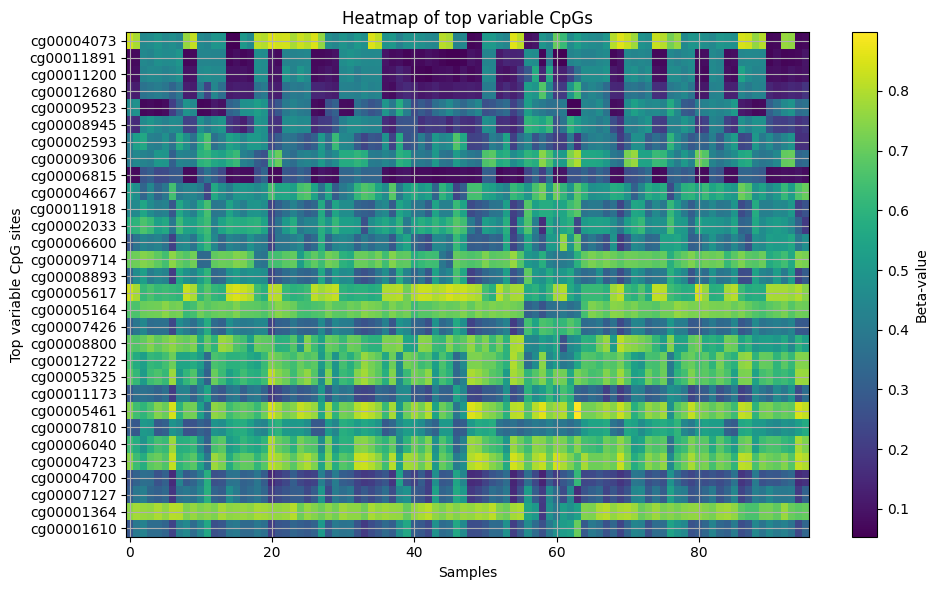

Original beta matrix shape: (500, 96)
After removing CpGs with >20% NaN: (500, 96)
Any remaining NaN? False
Explained variance ratio (PC1, PC2): [0.26345022 0.18493462]


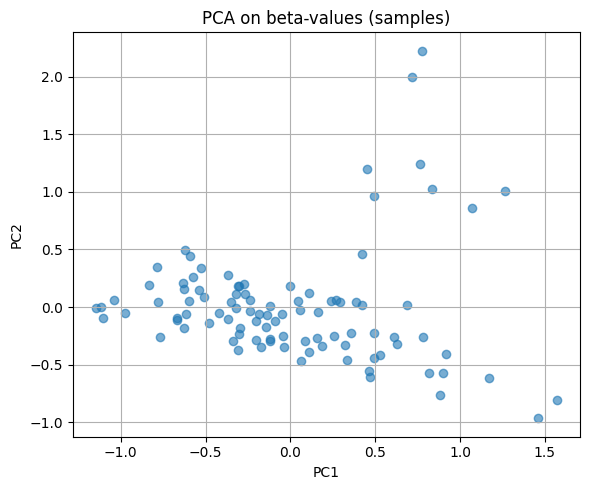

In [5]:
import pandas as pd # for DataFrame
import numpy as np # for numerical operations
import matplotlib.pyplot as plt # For plots (graphics, heatmaps...)
from pathlib import Path

# Basic plot style

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

# Project paths: this assumes the notebook is in the "notebooks" folder
PROJECT_ROOT = Path().resolve()
DATA_PROC = PROJECT_ROOT / "data" / "processed"

print("Project root:", PROJECT_ROOT)
print("Processed data folder:", DATA_PROC)

# Load processed metadata and beta-value matrices
meta = pd.read_csv(DATA_PROC / "metadata_aligned.csv")
beta = pd.read_csv(DATA_PROC / "beta_values_aligned.csv")

print("Metadata shape:", meta.shape)
print("Beta matrix shape:", beta.shape)

meta.head()

# Show all metadata columns to understand what information is available
pd.set_option("display.max_columns", None)
meta.head(3)

basic_cols = []

if "sex" in meta.columns:
    basic_cols.append("sex")
if "age" in meta.columns:
    basic_cols.append("age")

print("Basic columns found:", basic_cols)

# Descriptive statistics for the basic demographic variables
meta[basic_cols].describe(include="all")
if "sex" in meta.columns:
    sex_counts = meta["sex"].value_counts(dropna=False)
    print(sex_counts)

    plt.figure()
    sex_counts.plot(kind="bar")
    plt.title("Sex distribution in GSE72680")
    plt.xlabel("Sex")
    plt.ylabel("Number of samples")
    plt.tight_layout()
    plt.show()
else:
    print("No 'sex' column found in metadata.")

# Age distribution 
if "age" in meta.columns:
    ages = meta["age"].dropna()

    # Try to convert to numeric if needed
    ages = pd.to_numeric(ages, errors="coerce").dropna()

    plt.figure()
    ages.hist(bins=20)
    plt.title("Age distribution")
    plt.xlabel("Age (years)")
    plt.ylabel("Number of samples")
    plt.tight_layout()
    plt.show()
else:
    print("No 'age' column found in metadata.")

# Automatically detect columns related to trauma, abuse, stress, PTSD, depression, etc.
keywords = ["trauma", "abuse", "stress", "ptsd", "depress", "anxiety"]
trauma_cols = [c for c in meta.columns
                if any(k in c.lower() for k in keywords)]

print("Potential trauma / abuse / stress columns:")
for c in trauma_cols:
    print("-", c)

# Replace this string by the exact trauma/abuse column name from trauma_cols
TRAUMA_COL = "childhood_sexual/physical_abuse_moderate_to_extreme"  # <- ADAPT TO YOUR COLUMN NAME

if TRAUMA_COL in meta.columns:
    print(meta[TRAUMA_COL].value_counts(dropna=False))

    plt.figure()
    meta[TRAUMA_COL].value_counts().plot(kind="bar")
    plt.title(f"Distribution of '{TRAUMA_COL}'")
    plt.xlabel("Category")
    plt.ylabel("Number of samples")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print(f"Column '{TRAUMA_COL}' not found in metadata. Please adjust the name.")

# Age according to trauma category (if needed)
if "age" in meta.columns and TRAUMA_COL in meta.columns:
    subset = meta[["age", TRAUMA_COL]].dropna()

    # Convert age to numeric if possible
    subset["age"] = pd.to_numeric(subset["age"], errors="coerce")
    subset = subset.dropna(subset=["age"])

    categories = subset[TRAUMA_COL].unique()
    print("Trauma categories:", categories)

    plt.figure()
    for cat in categories:
        ages_cat = subset.loc[subset[TRAUMA_COL] == cat, "age"]
        plt.hist(ages_cat, bins=15, alpha=0.5, label=str(cat))
    plt.title(f"Age distribution by {TRAUMA_COL}")
    plt.xlabel("Age (years)")
    plt.ylabel("Number of samples")
    plt.legend(title=TRAUMA_COL)
    plt.tight_layout()
    plt.show()
else:
    print("Cannot plot age vs trauma: required columns are missing.")

#Detect automatically columns linked to traumas 
keywords = ["trauma", "abuse", "stress", "ptsd", "depress", "anxiety"]
trauma_cols = [c for c in meta.columns
                if any(k in c.lower() for k in keywords)]

print("Potential trauma / abuse / stress columns:")
for c in trauma_cols:
    print("-", c)

# Quick look at the beta matrix
print("Beta matrix shape:", beta.shape)
beta.head()

# Separate CpG identifiers and numeric beta-values

# First column is CpG_ID
cpg_ids = beta["CpG_ID"]

# All other columns are beta-values for each sample
beta_values = beta.drop(columns=["CpG_ID"])

print("Number of CpG sites:", beta_values.shape[0])
print("Number of samples:", beta_values.shape[1])

# Flatten all beta-values into a single 1D array (shows which CpG change the most between individuals)
all_beta = beta_values.values.flatten().astype(float)

plt.figure()
plt.hist(all_beta, bins=50)
plt.title("Global distribution of beta-values (all CpGs, all samples)")
plt.xlabel("Beta-value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Simple heatmap of the most variable CpGs across samples
# Compute variance of each CpG across samples
cpg_variance = beta_values.var(axis=1)
# Take the 30 most variable CpGs (or fewer if needed)
n_top = 30
top_idx = np.argsort(-cpg_variance)[:n_top]

beta_top = beta_values.iloc[top_idx]

plt.figure(figsize=(10, 6))
plt.imshow(beta_top, aspect="auto", interpolation="nearest")
plt.colorbar(label="Beta-value")
plt.yticks(ticks=range(n_top), labels=cpg_ids.iloc[top_idx])
plt.xlabel("Samples")
plt.ylabel("Top variable CpG sites")
plt.title("Heatmap of top variable CpGs")
plt.tight_layout()
plt.show()

# --- PCA on beta-values with NA cleaning ---

# 0) Import PCA (with a friendly message if scikit-learn is missing)
try:
    from sklearn.decomposition import PCA
except ModuleNotFoundError:
    print("scikit-learn is not installed.\n"
            "Run this in a new cell:  !pip install scikit-learn")
    raise

# 1) Start from beta_values (CpGs in rows, samples in columns)
#    Make sure everything is numeric; non-numeric values become NaN.
beta_numeric = beta_values.apply(pd.to_numeric, errors="coerce")

print("Original beta matrix shape:", beta_numeric.shape)

# 2) Remove CpG sites (rows) with too many missing values
#    Here we keep CpGs with less than 20% NaN across samples.
missing_fraction = beta_numeric.isna().mean(axis=1)
beta_filtered = beta_numeric[missing_fraction < 0.20]

print("After removing CpGs with >20% NaN:", beta_filtered.shape)

# 3) Replace remaining NaN by the mean beta-value of that CpG (row-wise mean)
row_means = beta_filtered.mean(axis=1)
beta_filled = beta_filtered.T.fillna(row_means).T  # fill NaN per CpG

print("Any remaining NaN?", beta_filled.isna().any().any())

# 4) Build matrix X for PCA: samples in rows, CpGs in columns
X = beta_filled.T.values        # shape: (n_samples, n_cpgs)

# 5) Center the data (subtract mean per CpG)
X_mean = X.mean(axis=0)
X_centered = X - X_mean

# 6) Run PCA (2 components)
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_centered)

print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)

# 7) Plot PCA scatter (each point = one sample)
plt.figure(figsize=(6, 5))
plt.scatter(pcs[:, 0], pcs[:, 1], alpha=0.6)
plt.title("PCA on beta-values (samples)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

# 🧬 Exploratory DNA Methylation Analysis — GSE72680 (Candace Lewis et al.)

This notebook presents a first-pass exploration of the DNA methylation dataset **GSE72680**, extracted from GEO and processed into aligned metadata and beta-value matrices.  
The goal is to verify data structure, sample composition, methylation signal quality, and global patterns before any downstream analysis.

---

## ## 1. Sex distribution in the dataset
This bar plot shows the number of male and female participants in GSE72680.

### **Interpretation**
- The dataset is **balanced**, with approximately **48 males** and **48 females**.  
- This balance is ideal for downstream comparisons, especially when investigating sex-related or stress-related epigenetic differences.  
- No sex-based sampling bias is present.

---

## ## 2. Global distribution of beta-values (all CpGs, all samples)
This histogram shows the overall distribution of DNA methylation beta-values across **all CpG sites** and **all samples combined**.

### **Interpretation**
- The distribution displays the **classic bi-modal shape** of DNA methylation data.  
- **Peak near 0–0.2:** mostly *unmethylated* CpGs.  
- **Peak near 0.7–0.9:** largely *methylated* CpGs.  
- Intermediate values represent partially methylated regions or heterogeneous cell composition.  
- This confirms that the dataset is **biologically coherent** and typical of Illumina EPIC/450K methylation array outputs.

---

## ## 3. Heatmap of top variable CpG sites
This heatmap shows the CpGs with the **highest variance** across samples.

### **Interpretation**
- High-variance CpGs reveal substantial **inter-individual differences** in methylation.  
- No strong visual clustering appears, suggesting that **no dominant batch effect** or **major grouping factor** is driving global variability.  
- This is expected in developmental or psychosocial stress datasets, where methylation effects tend to be **localized and subtle**, not global.

---

## ## 4. PCA on beta-values (samples)
This PCA plot visualizes the first two principal components from the full methylation matrix.

### **Interpretation**
- Samples form a **continuous cloud**, with no distinct clusters.  
- No clear separation by sex or other unmodeled factors is visible in PC1 or PC2.  
- This implies:
  - No major batch effect.
  - No dominating technical artifact.
  - Biological variability is **distributed**, not structured in large blocks.

PCA therefore supports the conclusion that the data is **clean** and suitable for downstream statistical modeling or epigenome-wide association analysis (EWAS).

---

## ## Summary of findings
- The dataset contains **balanced sex representation**.  
- Beta-value distributions are **normal and high-quality**, showing expected methylation patterns.  
- Variability across CpGs and samples appears **biologically typical**.  
- PCA shows **no clustering**, indicating **no strong batch effects**.

Overall, these exploratory analyses confirm that **GSE72680 is well-structured, high-quality, and ready for downstream analyses**.
